In [1]:
import amici
import amici.plotting
import pesto

## AMICI model

libSBML Warning (SBML unit consistency): In situations where a mathematical expression refers to a compartment, species or parameter, it is necessary to know the units of the object to establish unit consistency. In models where the units of an object have not been declared, libSBML does not yet have the functionality to accurately verify the consistency of the units in mathematical expressions referring to that object. 
 The units of the <parameter> 'R1_k2' cannot be fully checked. Unit consistency reported as either no errors or further unit errors related to this object may not be accurate.

libSBML Warning (SBML unit consistency): If the attribute 'units' on a given Parameter object has not been set, then the unit of measurement associated with that parameter's value is undefined.
Reference: L3V1 Section 4.7.3
 The <parameter> with id 'R1_k2' does not have a 'units' attribute.

libSBML Warning (SBML unit consistency): In situations where a mathematical expression refers to a compar

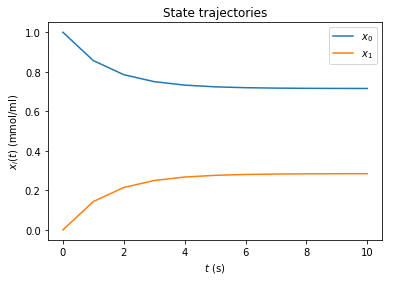

In [2]:
import importlib
import os
import sys
import numpy as np

# sbml file we want to import
sbml_file = 'model_conversion_reaction.xml'
# name of the model that will also be the name of the python module
model_name = 'model_conversion_reaction'
# directory to which the generated model code is written
model_output_dir = model_name

# import sbml model, complile and generate amici module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         verbose=False)

# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11)))
model.setParameterScale(amici.AMICI_SCALING_LOG10)
model.setParameters(amici.DoubleVector([-0.3,-0.7]))
solver = model.getSolver()
solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata['ptr'].get(), 0.1, 0.0)

## Optimization

In [3]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective, 
# the general pesto objective function class
objective = pesto.objective.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = pesto.optimize.optimizer.ScipyOptimizer()

#optimizer.solver = 'bfgs|meigo'
# if select meigo -> also set default values in solver_options
#optimizer.options = {'maxiter': 1000, 'disp': True} # = pesto.default_options_meigo()
#optimizer.startpoints = []
#optimizer.startpoint_method = 'lhs|uniform|something|function'
#optimizer.n_starts = 100

# see PestoOptions.m for more required options here
# returns OptimizationResult, see parameters.MS for what to return
# list of final optim results foreach multistart, times, hess, grad, 
# flags, meta information (which optimizer -> optimizer.get_repr())

# create problem object containing all information on the problem to be solved
problem = pesto.problem.Problem(objective, [-2,-2], [2,2])

# maybe lb, ub = inf
# other constraints: kwargs, class pesto.Constraints
# constraints on pams, states, esp. pesto.AmiciConstraints (e.g. pam1 + pam2<= const)
# if optimizer cannot handle -> error
# maybe also scaling / transformation of parameters encoded here

# do the optimization
result = pesto.optimize.minimize(problem, optimizer, 10, startpoint_method=pesto.optimize.startpoint.uniform)
print(result)
# optimize is a function since it does not need an internal memory,
# just takes input and returns output in the form of a Result object
# 'result' parameter: e.g. some results from somewhere -> pick best start points

/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:513: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)


## Visualize

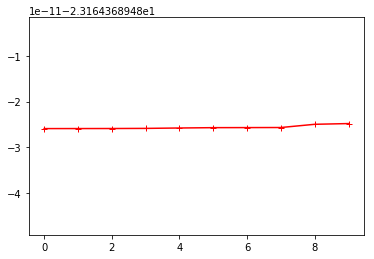

In [4]:
# waterfall, parameter space, scatter plots, fits to data
# different functions for different plotting types
import matplotlib.pyplot as plt

plt.plot(result.get_optimizer_results_for_key('fval'), '-r+',)

#pesto.plot_waterfall(problem, result)

## Data storage

## Profiles

In [ ]:
# there are three main parts: optimize, profile, sample. the overall structure of profiles and sampling
# will be similar to optimizer like above.
# we intend to only have just one result object which can be reused everywhere, but the problem of how to 
# not have one huge class but
# maybe simplified views on it for optimization, profiles and sampling is still to be solved

profiler = pesto.Profiler()

result = pesto.profile(problem, profiler, result=None)
# possibly pass result object from optimization to get good parameter guesses

## Sampling

In [ ]:
sampler = pesto.Sampler()

result = pesto.sample(problem, sampler, result=None)

In [ ]:
# open: how to parallelize. the idea is to use methods similar to those in pyabc for working on clusters.
# one way would be to specify an additional 'engine' object passed to optimize(), profile(), sample(),
# which in the default setting just does a for loop, but can also be customized.